<h5 style="color: orange; font-weight: bold;">The Data:</h5>

https://www.kaggle.com/datasets/himanshuydv11/facial-emotion-dataset

In [1]:
# Importe
import os
import torch
import hashlib
import random
import numpy as np 
import time
import seaborn as sns
from PIL import Image
import tensorflow as tf
import torch.optim as optim
import torch.nn as nn
import copy
from shutil import copy2
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Laden des Datensatzes
data_dir = r'facial_emotion_dataset'
classes = os.listdir(data_dir) # Klassen im Verzeichnis auflisten

In [3]:
# Datensatz mit ImageFolder einlesen
dataset = ImageFolder(data_dir)

In [4]:
# Zeige die ersten 5 Einträge im ImageFolder
for i, sample in enumerate(dataset.samples[:5]):
    print(f"Eintrag {i + 1}: {sample}")

Eintrag 1: ('facial_emotion_dataset\\Happy\\000a72729218f928b4a9017cd09f71e30126ce497fe54446b94a90ea.JPG', 0)
Eintrag 2: ('facial_emotion_dataset\\Happy\\000ad778e32e1c44f2ec87c991390e24e504de01d710fe9081aa0e75.jpg', 0)
Eintrag 3: ('facial_emotion_dataset\\Happy\\000be90a828409ffe480ba9b3b8bab5fcad49c341a535dacb289d849.jpg', 0)
Eintrag 4: ('facial_emotion_dataset\\Happy\\000ca24489f124e628370955605ca4e0112d2d18727cc0c9784ff5f1.jpg', 0)
Eintrag 5: ('facial_emotion_dataset\\Happy\\002d58c033395fe86d8ec7959eba4233043c2b1ba004930686680808.jpg', 0)


In [5]:
# Klassenzuordnung
dataset.class_to_idx

{'Happy': 0, 'Neutral': 1}

Der Datensatz besteht aus Bildern, die in zwei Klassen unterteilt sind: ``„Happy“`` und ``„Neutral“``. Diese Bilder sind in separaten Ordnern organisiert, was eine klare Trennung der Klassen ermöglicht. Durch das Einlesen in **ImageFolder** wird die Ordnerstruktur automatisch als Grundlage für die Zuordnung der Labels verwendet. Dies erleichtert den Aufbau eines sauberen Trainingsdatensatzes, da jedes Bild automatisch mit dem korrekten Label verknüpft wird.

In [6]:
# Anzahl der Bilder je Klasse
label_counts = Counter(dataset.targets)
for label, count in label_counts.items():
    print(f"{dataset.classes[label]}: {count} Bilder")

Happy: 3740 Bilder
Neutral: 4027 Bilder


Die Anzahl der Bilder je Klasse ist ähnlich, sodass keine zusätzlichen Maßnahmen zur Anpassung der Klassenverteilung, wie etwa Downsampling oder Upsampling, erforderlich sind.

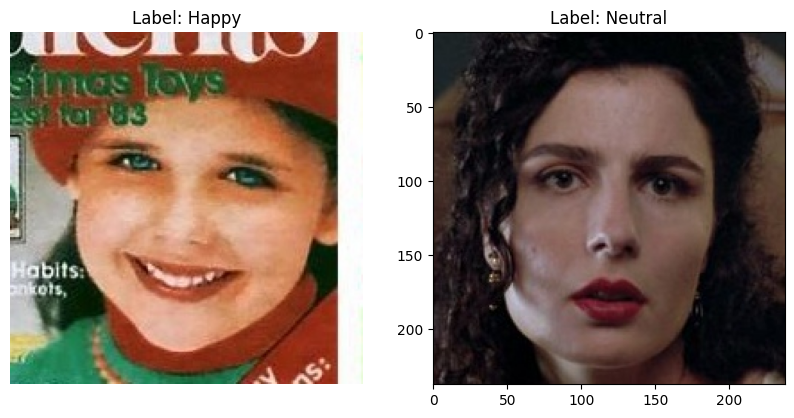

In [ ]:
###### Erstes Bild je Klasse anzeigen ######

# Bild in einen Tensor umwandeln
transform = transforms.Compose([
    transforms.ToTensor()
])

# Datensatz mit der ToTensor-Transformation laden
dataset = ImageFolder(data_dir, transform=transform)

# Index des ersten "Neutral"-Bildes bestimmten
neutral_start_index = dataset.targets.index(1) 

# Subplot-Funktion 
def show_two_images(img1, label1, img2, label2, dataset):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 
    # Erstes Bild (Happy)
    axes[0].imshow(torch.permute(img1, (1, 2, 0)))  # Bild dimensionieren
    axes[0].set_title(f'Label: {dataset.classes[label1]}')  # Titel mit Klassennamen
    axes[0].axis('off') 
    # Zweites Bild (Neutral)
    axes[1].imshow(torch.permute(img2, (1, 2, 0)))  
    axes[1].set_title(f'Label: {dataset.classes[label2]}') 
    plt.show()

# Bild und Label für das erste "Happy"-Bild und "Neutral"-Bild 
img_happy, label_happy = dataset[0]  # Index 0: Happy
img_neutral, label_neutral = dataset[neutral_start_index]  # Erstes Bild aus der Klasse Neutral

show_two_images(img_happy, label_happy, img_neutral, label_neutral, dataset)

Dieser Datensatz ist für die Klassifizierungs-Aufgabe geeignet, da er 3740 „Happy“-Bilder und 4027 „Neutral“-Bilder von Personen enthält. Damit steht ein ausgewogener Datensatz mit genügend Bildern beider Klassen zur Verfügung, um beide Emotionen zuverlässig zu erlernen. Die Vielfalt der Gesichter im Datensatz trägt dazu bei, Biases zu vermeiden und dem Kunden solide und verlässliche Ergebnisse zu liefern.


<h5 style="color: orange; font-weight: bold;">IDA - Initial Data Analysis:</h5>

``Bilddimensionen überprüfen:``

In [ ]:
for i in range(10):  # Überprüfe die Dimensionen der ersten 5 Bilder
    img, label = dataset[i]
    print(f"Bild {i + 1} hat die Dimensionen: {img.shape}")

Bild 1 hat die Dimensionen: torch.Size([3, 197, 197])
Bild 2 hat die Dimensionen: torch.Size([3, 196, 196])
Bild 3 hat die Dimensionen: torch.Size([3, 367, 367])
Bild 4 hat die Dimensionen: torch.Size([3, 219, 219])
Bild 5 hat die Dimensionen: torch.Size([3, 1180, 1180])
Bild 6 hat die Dimensionen: torch.Size([3, 587, 587])
Bild 7 hat die Dimensionen: torch.Size([3, 197, 197])
Bild 8 hat die Dimensionen: torch.Size([3, 393, 393])
Bild 9 hat die Dimensionen: torch.Size([3, 599, 599])
Bild 10 hat die Dimensionen: torch.Size([3, 815, 815])


In [ ]:
# minimale und maximale Bild-Dimensionen prüfen
min_height, min_width = float('inf'), float('inf')
max_height, max_width = 0, 0

for img, label in dataset:
    _, height, width = img.shape
    # Aktualisiere minimale und maximale Dimensionen
    if height < min_height:
        min_height = height
    if width < min_width:
        min_width = width
    if height > max_height:
        max_height = height
    if width > max_width:
        max_width = width

print(f"Minimale Bildgröße: Höhe = {min_height}, Breite = {min_width}")
print(f"Maximale Bildgröße: Höhe = {max_height}, Breite = {max_width}")

Die Bilddimensionen weisen eine große Variabilität und einige Anomalien auf, weshalb im Preprocessing-Schritt eine einheitliche Größe festgelegt wird. Dies sorgt für eine konsistente Eingabegröße und beschleunigt die Verarbeitung im Modelltraining.

``Untersützte Dateiformate in ImageFolder überprüfen:``

In [ ]:
# Zeige die unterstützten Dateiformate an
print("Unterstützte Dateiformate:", dataset.extensions)

Unterstützte Dateiformate: ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')


``Verteilung der Bildformate im Datensatz:``

In [ ]:
format_counter = defaultdict(int)
for path, _ in dataset.samples:  # 'samples' enthält Bildpfade und Labels
    ext = path.split('.')[-1].lower()  # Dateiendung extrahieren
    format_counter[ext] += 1

# Ausgabe der Bildformate
print("Verteilung der Bildformate:")
for ext, count in format_counter.items():
    print(f"{ext}: {count} Bilder")

Verteilung der Bildformate:
jpg: 5135 Bilder
png: 2483 Bilder
jpeg: 146 Bilder
bmp: 3 Bilder


Die vorhandenen Bilder liegen in verschiedenen Formaten vor. Um die Verarbeitung im Training zu vereinfachen und die Modellleistung zu optimieren, werden die Bilder im Preprocessing Schritt in ein einheitliches Format konvertiert.

``Bilder auf Dubletten überprüfen``

### Identifizierung von Dubletten durch Hash-Code Vergleich: 

###### https://realpython.com/fingerprinting-images-for-near-duplicate-detection/ ; https://stackoverflow.com/questions/18724376/finding-duplicate-files-via-hashlib ; https://github.com/CodingWithCard/Duplicate_Image_Finder/blob/main/duplicate_image_finder.py

Es wurden 23 Duplikatgruppen gefunden.
Duplikate für Hash-Code: c74e39f377372797653229ee3ab70555e9383a5dc70245284996ffc1f270ec7b


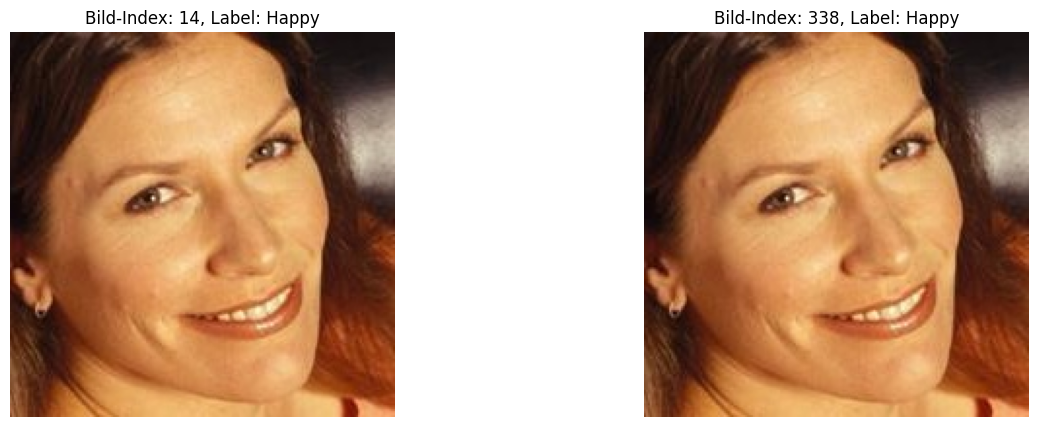

Duplikate für Hash-Code: 31e13fd9ca2f29e160681d34797b46059856959b33ba96a5b53e00a998e7c263


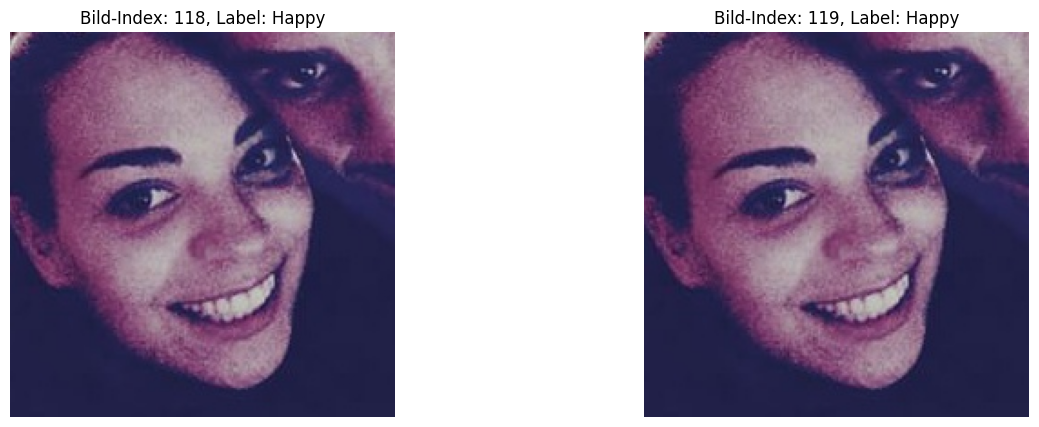

Duplikate für Hash-Code: 4dfa80f34ebed8540010fef58e6ed0a03b111d567b105ec6711836fdd805cf4d


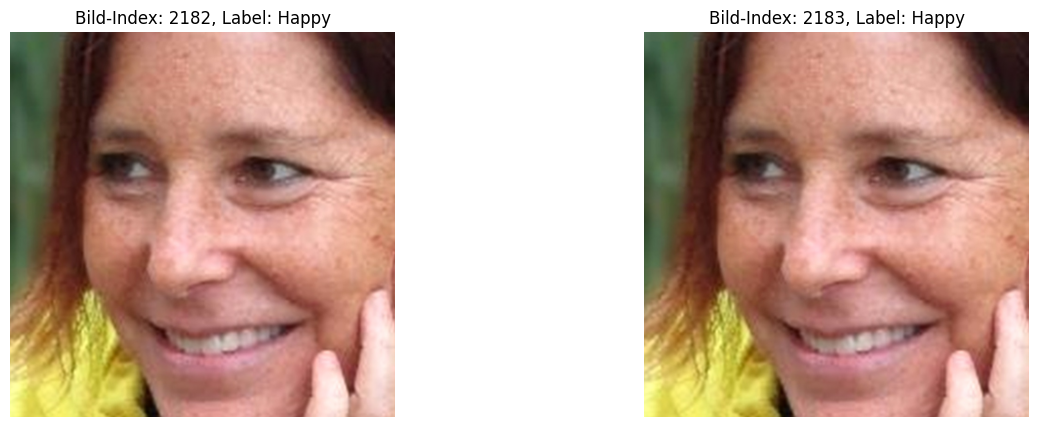

Duplikate für Hash-Code: da61bac0016f5c7ef62c7e41b3b88dc681117987c18bedeccf8d2ac286611c35


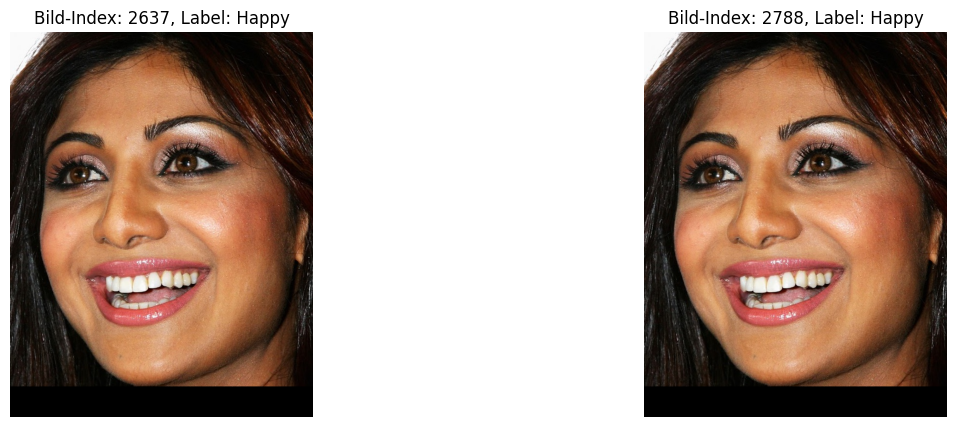

Duplikate für Hash-Code: cdfd9b6fefc1b5047768ced68aa7b74ff10e9e793029d1a06b14e046587c71b7


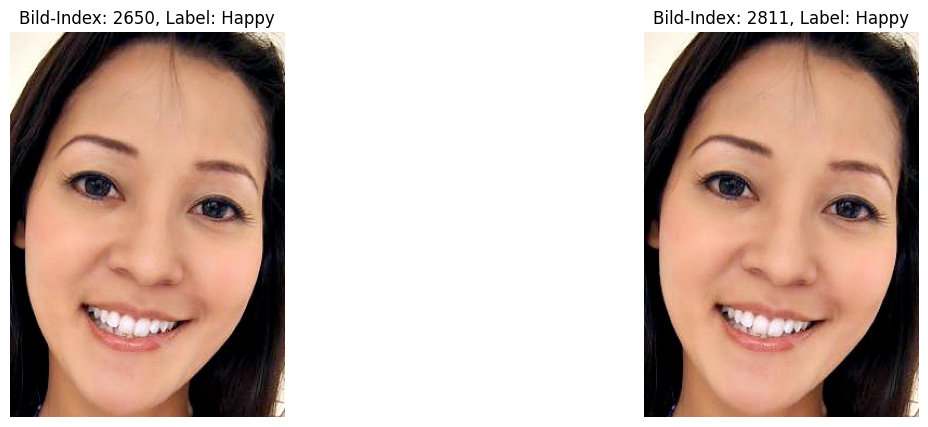

Duplikate für Hash-Code: 2b2763b8fb764793690cbd5f9aeee7c392cf4a7561b3583a4a3af015843dbc45


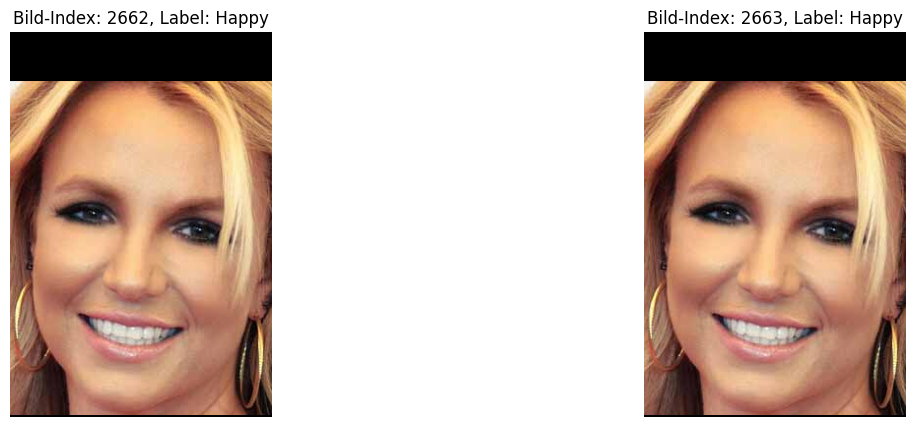

Duplikate für Hash-Code: bff5134d5d60a0896ff6421044cc030c8b72157e03baef3b774a0d573652b0b1


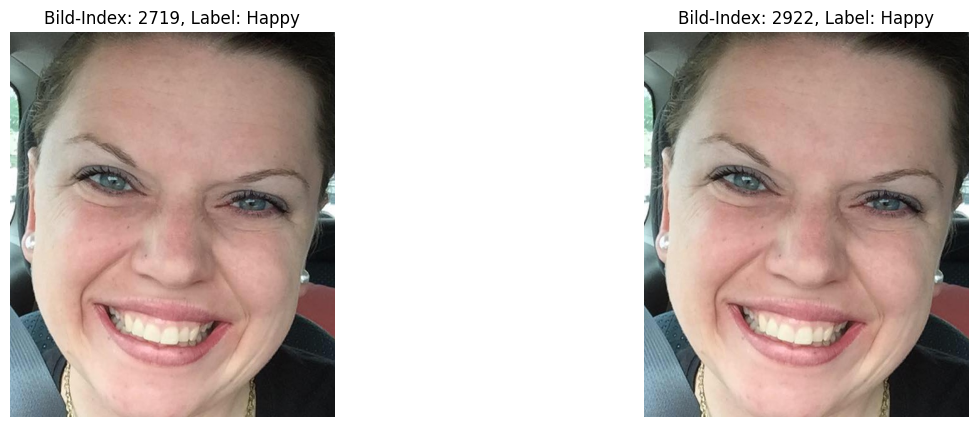

Duplikate für Hash-Code: ef3e698b6d2b9cf3340fbea6817d08feac314ca103d6b13138b8144e2e32525a


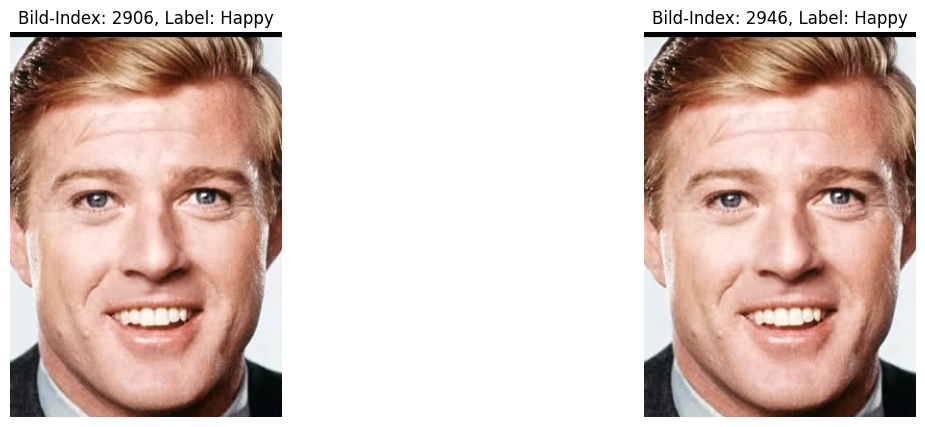

Duplikate für Hash-Code: 350580e9387b816a104c6f5178e667bc8b7ffacf54f394dadd1ebe7bc03f799c


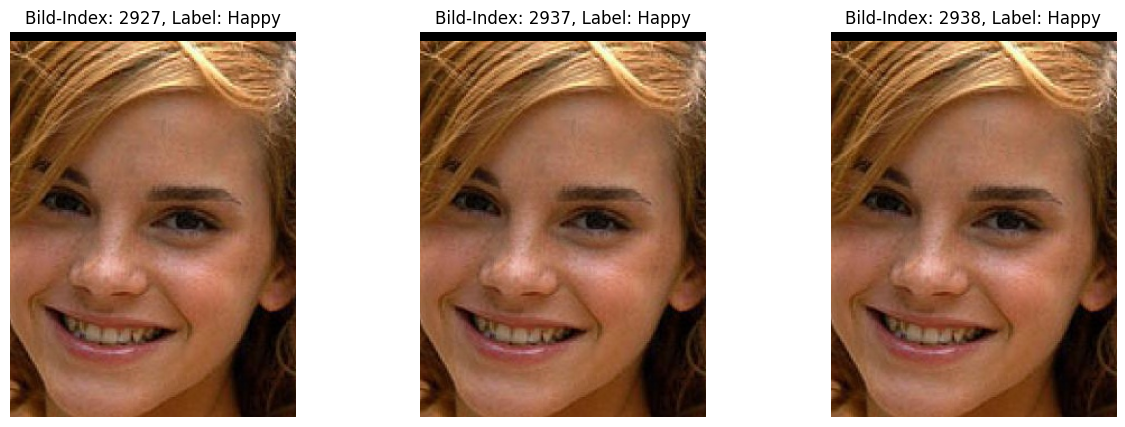

Duplikate für Hash-Code: 70330446ed4185c551186ca1d83b9a6f6b123ee8ec31bd5db1b657a4b6fddd40


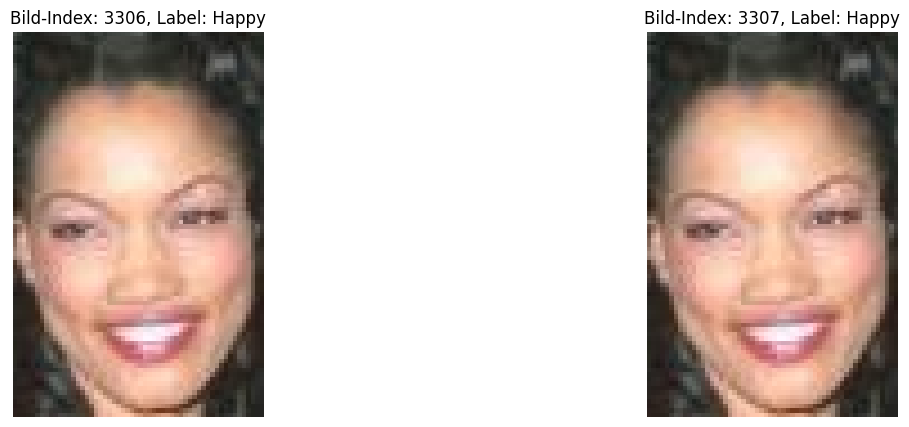

Duplikate für Hash-Code: aba972a8f208cc8042f9fcbe28ea7c0d2af48999050b368bdf1289a39a46ef0c


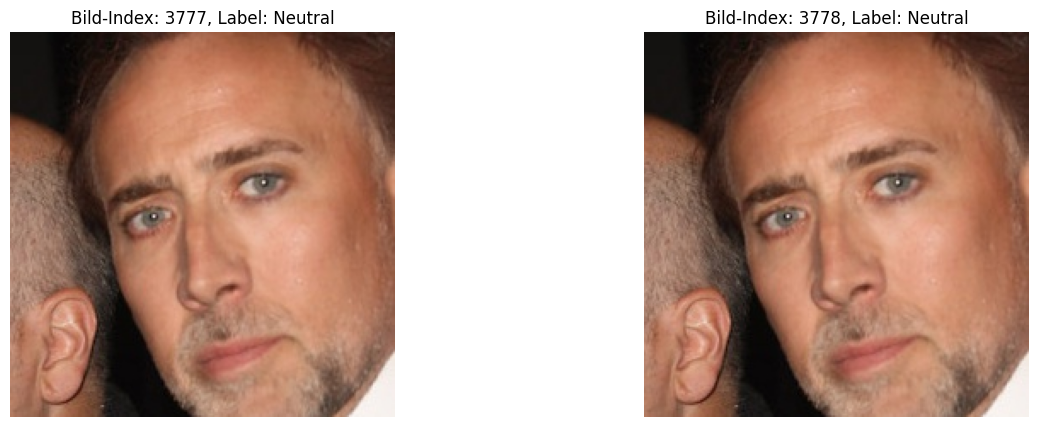

Duplikate für Hash-Code: e91c02b88c831c27d30f978ed7f17b7c180d62460b1f9f50bac95a8748e91181


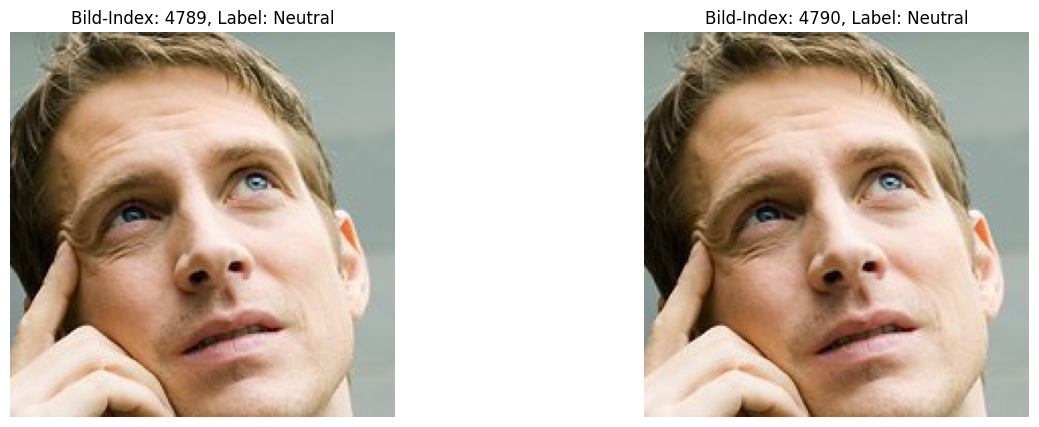

Duplikate für Hash-Code: d830ab45e160fe716f1a8c075cd10249a67f05cc16ded246966d666b640250c8


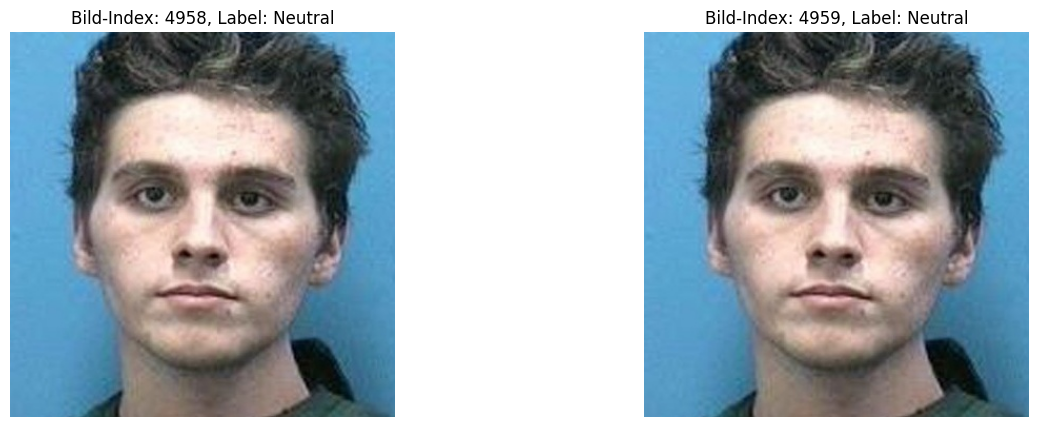

Duplikate für Hash-Code: d290396c5a3b0bbe42c666593d72f8b3f76f8764ff69f48f7dc92384efdcfa57


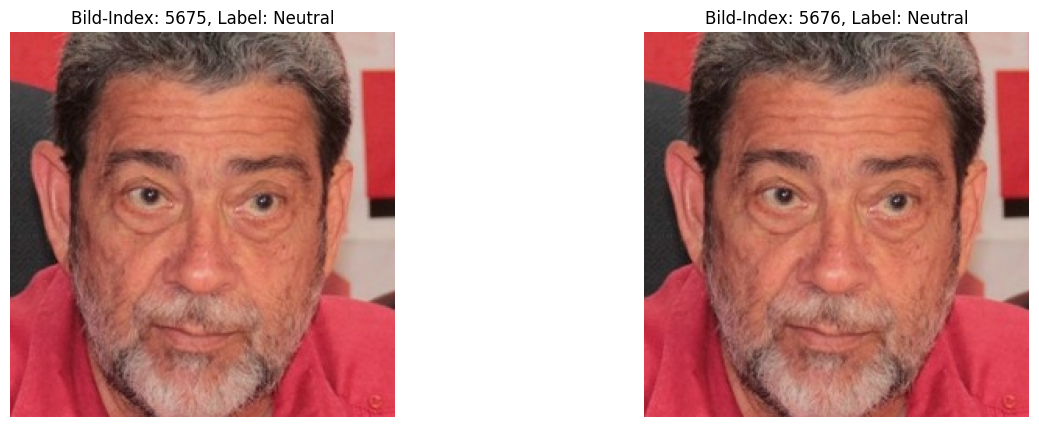

Duplikate für Hash-Code: 01908f15b0793f918319ccec5bfc2b461b96f8b68ab9a62246318a6197eec0b9


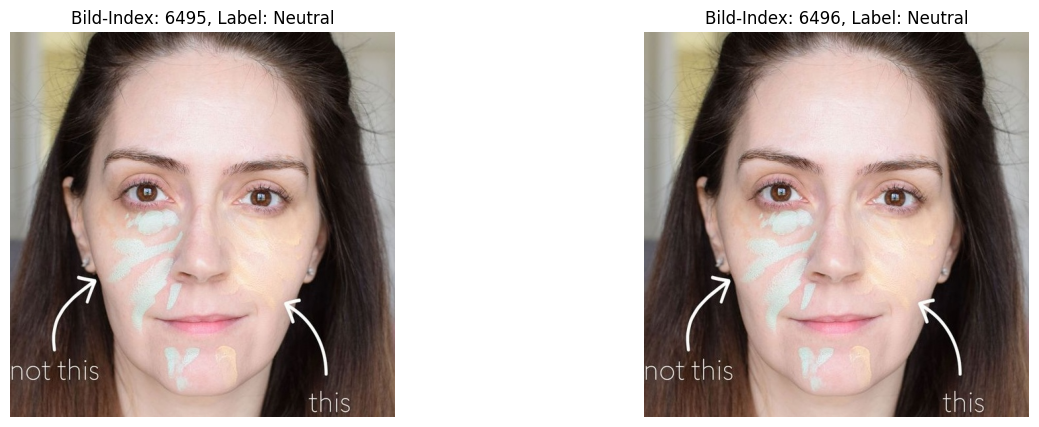

Duplikate für Hash-Code: d09a50cc03ee0473ee0b7fb5dfca1d0968b542d2139db144ba9ffe23c1fda83d


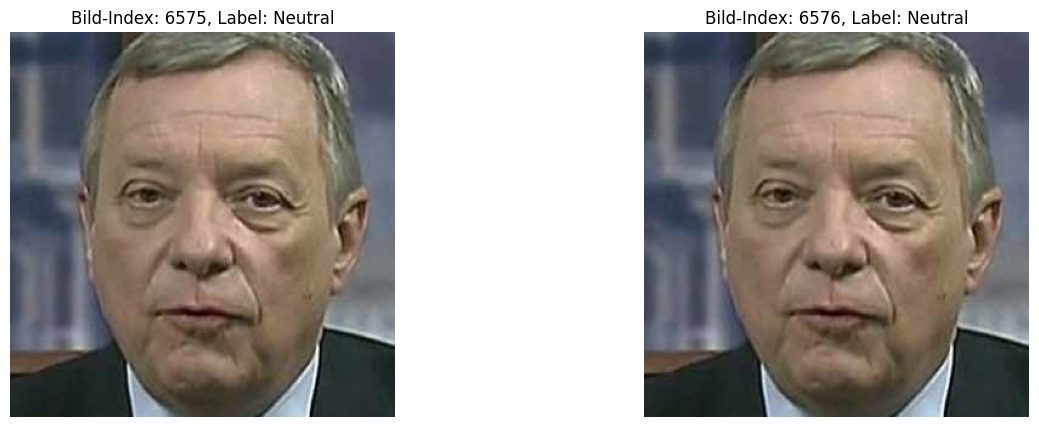

Duplikate für Hash-Code: e6b82127773bf1bb49c29d8fa88258f406ce11d85c4990e553981512ad9aa39f


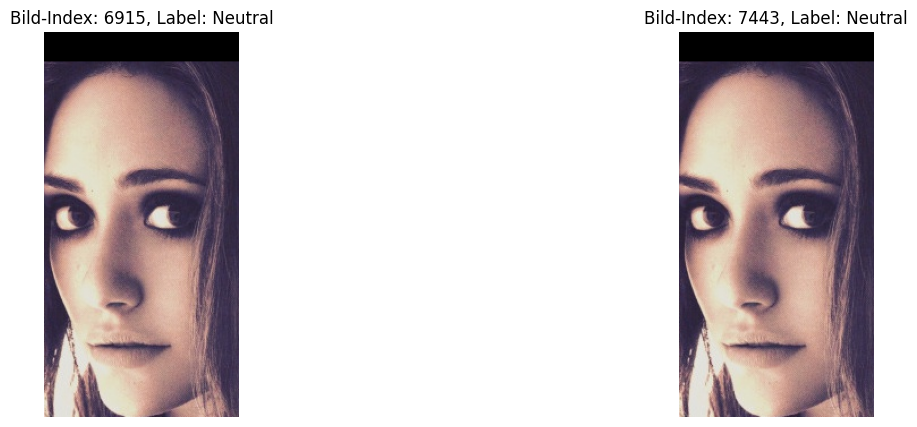

Duplikate für Hash-Code: 7e07481c1a7555e897e16bcecb63225f80e0ad167d46f7cb93c1eefabfeb4e1c


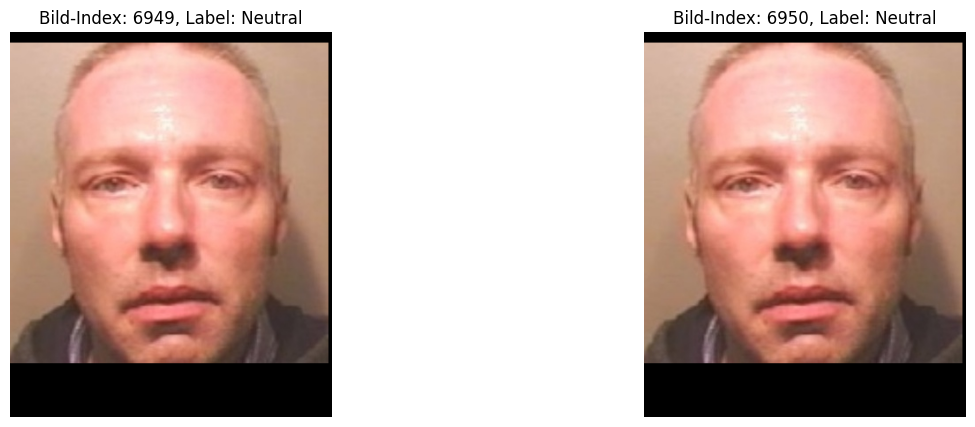

Duplikate für Hash-Code: 28ef85c580346e3e9d9c5e14ea59d774fa514a22a3cba0bef2c8aa39bc53ad2a


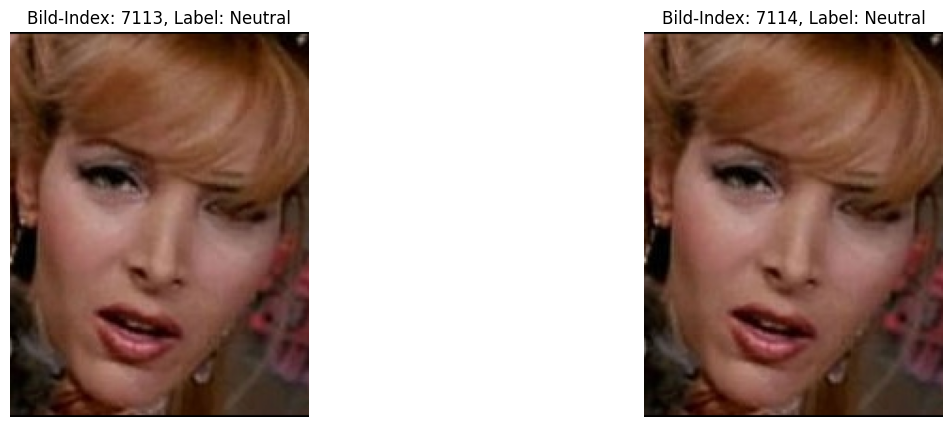

Duplikate für Hash-Code: 02f42e0118e62d6c87186e0bc6d2eb0195878d61523992053784f4353f229777


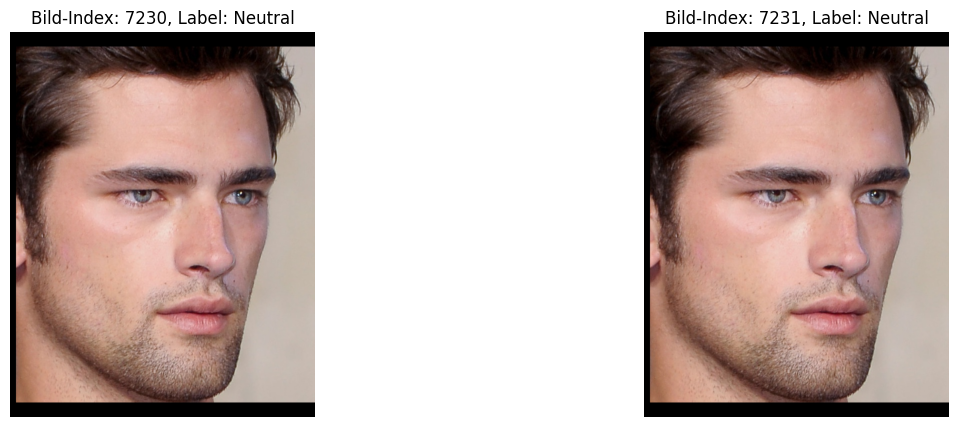

Duplikate für Hash-Code: 622dd9f1cecee9c2f06d9d22cc740fecce37964e54bee23500496d18d4ff8deb


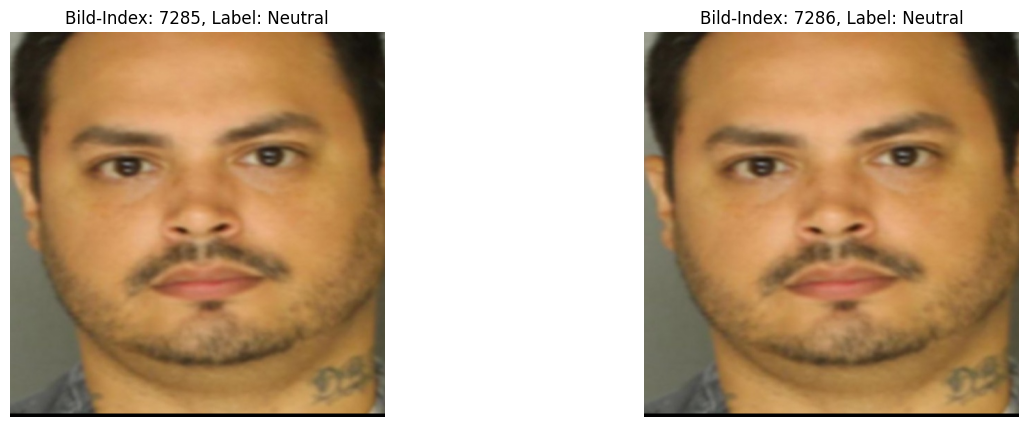

Duplikate für Hash-Code: d720374f6e70b8615f7665f56f16f31d8a8fa4b909a55050b1544a8f604f3ca5


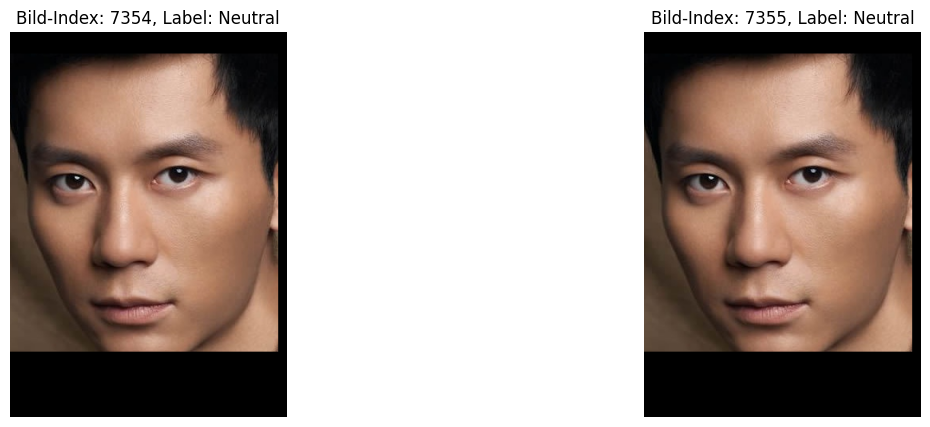

Duplikate für Hash-Code: b50fea707236a2492255217b29c378a912a518d23b16b4ea35350e19d8f045e8


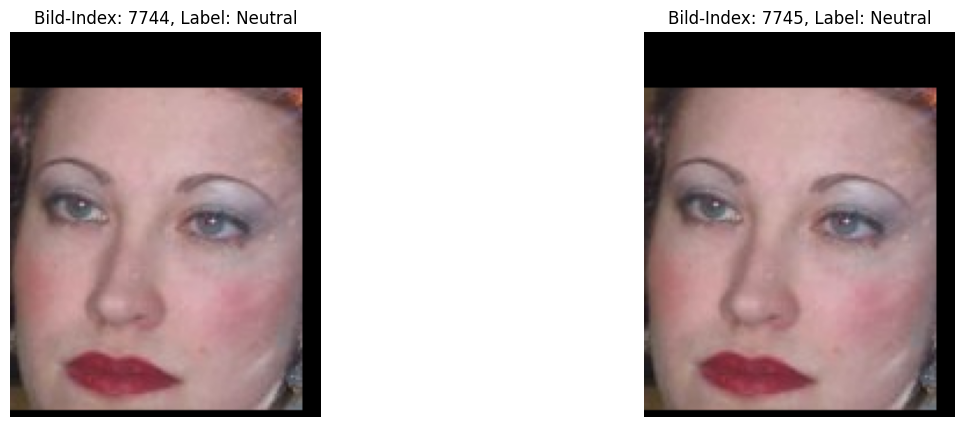

In [ ]:
# Funktion zur Berechnung des Hash-Codes eines Bildes
def get_image_hash(image_tensor):
    # Konvertiere den Tensor in ein numpy-Array (Channels, Height, Width -> Height, Width, Channels)
    img_array = image_tensor.permute(1, 2, 0).numpy()
    # Das Array in ein zusammenhängendes (C-contiguous) Format bringen
    img_array_contiguous = np.ascontiguousarray(img_array)
    # Erzeuge einen Hash basierend auf den Bilddaten
    hash_object = hashlib.sha256(img_array_contiguous)
    return hash_object.hexdigest()

# Dictionary für Hash-Codes und die zugehörigen Bild-Indizes
hash_map = defaultdict(list) 

# Schleife durch den Datensatz, um für jedes Bild den Hash zu berechnen
for idx, (img, label) in enumerate(dataset):
    hash_code = get_image_hash(img)
    hash_map[hash_code].append(idx)  # Index des Bildes für den berechneten Hash speichern

# Finde Duplikate (wenn mehrere Bilder denselben Hash haben)
duplicates = {hash_code: indices for hash_code, indices in hash_map.items() if len(indices) > 1}

# Anzahl der Duplikate anzeigen
print(f"Es wurden {len(duplicates)} Duplikatgruppen gefunden.")

# Funktion zum Anzeigen der Duplikate
def show_duplicates(duplicates, dataset):
    for hash_code, indices in duplicates.items():
        print(f"Duplikate für Hash-Code: {hash_code}")
        fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
        for i, idx in enumerate(indices):
            img, label = dataset[idx]
            axes[i].imshow(torch.permute(img, (1, 2, 0)))  # Bild dimensionieren
            axes[i].set_title(f"Bild-Index: {idx}, Label: {dataset.classes[label]}")
            axes[i].axis('off')
        plt.show()

show_duplicates(duplicates, dataset)

# Liste der eindeutigen Bild-Indizes erstellen
unique_indices = []
for indices in hash_map.values():
    unique_indices.append(indices[0])  # Nur den ersten Index jeder Duplikatgruppe hinzufügen

Der Datensatz hat 23 Dubletten. Doppelte Bilder können zu Overfitting führen, da das Modell sich zu stark auf wiederholte Muster konzentriert und schlechter generalisiert. Aus diesem Grund werde ich die doppelten Bilder im Preprocessing Schritt entfernen. Das Entfernen vermeidet Verzerrungen und sorgt für robustere Ergebnisse. Ich habe SHA256-Hashing genutzt, da es selbst kleine Unterschiede erkennt, auch wenn es zeitintensiver ist.

<h5 style="color: orange; font-weight: bold;">Preprocessing:</h5>

Im folgenden Schritt werden die in der IDA angesprochenen Preprocessing Schritte angewandt:

In [ ]:
# Funktion um Datensatz ohne Dublikate zu erstellen
def create_dataset_without_duplicates(dataset, unique_indices, target_dir):
    os.makedirs(target_dir, exist_ok=True)

    for idx in unique_indices:
        img_path = dataset.samples[idx][0]
        class_name = os.path.basename(os.path.dirname(img_path))
        
        # Ordnerstruktur im neuen Verzeichnis beibehalten
        target_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        
        # Bild kopieren
        target_path = os.path.join(target_class_dir, os.path.basename(img_path))
        copy2(img_path, target_path)

# Zielverzeichnis für den bereinigten Datensatz
new_data_dir = 'facial_emotion_dataset_cleaned'
create_dataset_without_duplicates(dataset, unique_indices, new_data_dir)

In [ ]:
# Funktion zur Größenanpassung und Konvertierung in ein einheitliches Format
def convert_and_resize_images(new_data_dir, target_format='JPEG', target_size=(256, 256)):
    for root, _, files in os.walk(new_data_dir):
        for file in files:
            file_path = os.path.join(root, file)
            img = Image.open(file_path)
            img = img.resize(target_size)  # Größe setzen
            # Neues Bild speichern, um das Format anzupassen
            img.save(file_path, format=target_format)

convert_and_resize_images(new_data_dir, target_format='JPEG')

In [ ]:
# Funktion zur Farbumwandlung in Graustufen
def convert_to_grayscale(new_data_dir):
    for root, _, files in os.walk(new_data_dir):
        for file in files:
            file_path = os.path.join(root, file)
            img = Image.open(file_path)
            img = img.convert("L") 
            img.save(file_path)

convert_to_grayscale(new_data_dir)

In diesem Schritt wird das Bild in Graustufen umgewandelt, weil dadurch der Fokus auf die Emotionen in den Gesichtsausdrücken gelegt wird, ohne dass Farben ablenken. Außerdem verringert das die Datenmenge und spart Rechenleistung im Training.

In [ ]:
### Neuen bereinigten Datensatz in ImageFolder einbinden ###

# Transformation, um Bilder als Graustufen zu laden und in Tensoren zu konvertieren
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Konvertiere in Graustufen mit einem Kanal
    transforms.ToTensor()
])

# Laden des Datensatzes
new_data_dir = r'facial_emotion_dataset_cleaned'
classes = os.listdir(new_data_dir) 

# Datensatz mit Transformation in ImageFolder laden
dataset_cleaned = ImageFolder(new_data_dir, transform=transform)

In [ ]:
# Prüfen der Bild-Dimensionen
for i in range(5): 
    img, label = dataset_cleaned[i]
    print(f"Bild {i + 1} hat die Dimensionen: {img.shape}")

Bild 1 hat die Dimensionen: torch.Size([1, 256, 256])
Bild 2 hat die Dimensionen: torch.Size([1, 256, 256])
Bild 3 hat die Dimensionen: torch.Size([1, 256, 256])
Bild 4 hat die Dimensionen: torch.Size([1, 256, 256])
Bild 5 hat die Dimensionen: torch.Size([1, 256, 256])


Die Größenanpassung, sowie Konvertierung in einen einzelnen Farbkanal (Graustufen) sind erfolgreich abgeschlossen.

In [ ]:
# Prüfen der Anzahl der Bilder je Klasse
label_counts = Counter(dataset_cleaned.targets)
for label, count in label_counts.items():
    print(f"{dataset_cleaned.classes[label]}: {count} Bilder")

Happy: 3729 Bilder
Neutral: 4014 Bilder


Die doppelten Bilder wurden erfolgreich aussortiert, wodurch nun ein bereinigter Datensatz ohne redundante Bilder für das Training zur Verfügung steht.

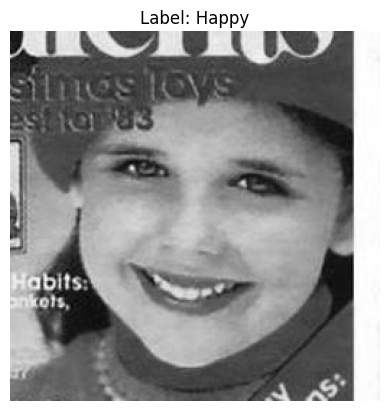

In [ ]:
# Funktion zum Anzeigen eines Bildes aus dataset_cleaned
def show_sample_image(dataset_cleaned, index=0):
    img, label = dataset_cleaned[index]  # Lade das Bild und das Label am angegebenen Index
    plt.imshow(img.squeeze(), cmap='gray')  # Zeige das Bild in Graustufen an
    plt.title(f"Label: {dataset_cleaned.classes[label]}")
    plt.axis('off') 
    plt.show()

show_sample_image(dataset_cleaned, index=0)

<h5 style="color: orange; font-weight: bold;">EDA:</h5>

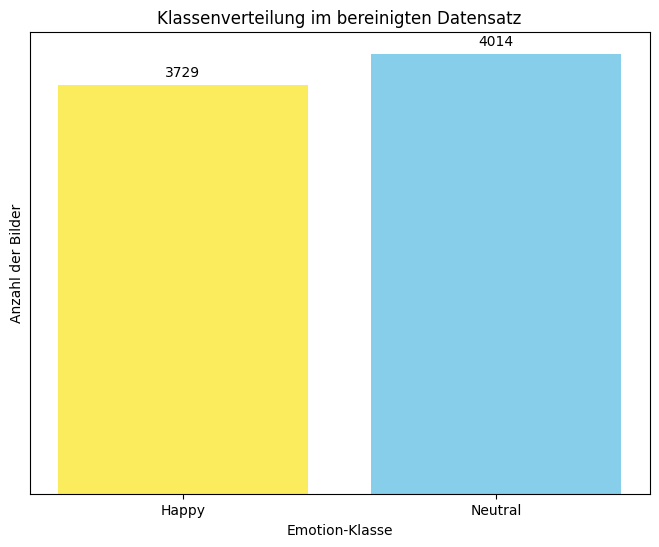

In [ ]:
# Anzahl der Bilder je Klasse zählen
label_counts = Counter(dataset_cleaned.targets)

# Klassen und ihre Anzahl
labels = [dataset_cleaned.classes[label] for label in label_counts.keys()]
counts = list(label_counts.values())

# Barplot erstellen
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color=['#FBEC5D', 'skyblue'])

# Y-Achsenbeschriftung setzen
plt.ylabel('Anzahl der Bilder')
plt.gca().set_yticks([])  # Zahlen auf der y-Achse entfernen

# Werte über den Balken anzeigen
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50, 
             str(count), ha='center', va='bottom')

plt.xlabel('Emotion-Klasse')
plt.title('Klassenverteilung im bereinigten Datensatz')
plt.show()

Die Klassenverteilung zwischen Happy und Neutral zeigt eine nahezu ausgeglichene Balance mit einer Abweichung von nur 3.68%, sodass keine weitere Verarbeitung notwendig ist.

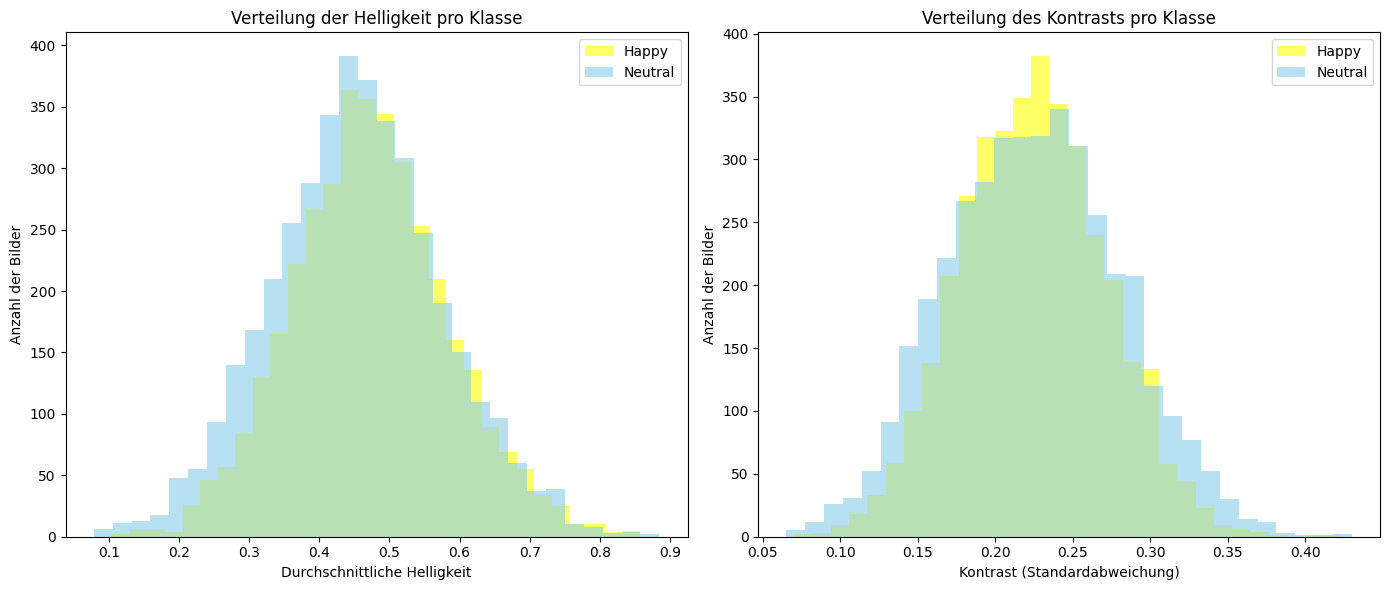

In [ ]:
# Listen zur Speicherung der Helligkeit (Mittelwert) und Kontrast (Standardabweichung) je Klasse
brightness_values_happy = []
contrast_values_happy = []
brightness_values_neutral = []
contrast_values_neutral = []

# Schleife über alle Bilder und Berechnung der Helligkeits- und Kontrastwerte
for img, label in dataset_cleaned:
    brightness = img.mean().item()
    contrast = img.std().item()
    
    # Werte je nach Klasse speichern
    if label == 0:  # 0 entspricht "Happy" in class_to_idx
        brightness_values_happy.append(brightness)
        contrast_values_happy.append(contrast)
    else:  # 1 entspricht "Neutral" in class_to_idx
        brightness_values_neutral.append(brightness)
        contrast_values_neutral.append(contrast)

# Visualisierung der Helligkeitsverteilung
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(brightness_values_happy, bins=30, alpha=0.6, color='yellow', label='Happy')
plt.hist(brightness_values_neutral, bins=30, alpha=0.6, color='skyblue', label='Neutral')
plt.xlabel('Durchschnittliche Helligkeit')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Helligkeit pro Klasse')
plt.legend()

# Visualisierung der Kontrastverteilung
plt.subplot(1, 2, 2)
plt.hist(contrast_values_happy, bins=30, alpha=0.6, color='yellow', label='Happy')
plt.hist(contrast_values_neutral, bins=30, alpha=0.6, color='skyblue', label='Neutral')
plt.xlabel('Kontrast (Standardabweichung)')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung des Kontrasts pro Klasse')
plt.legend()

plt.tight_layout()
plt.show()

###### https://www.analyticsvidhya.com/blog/2021/09/understanding-image-contrast-with-opencv-in-python/ ; https://www.analyticsvidhya.com/blog/2021/09/advanced-image-contrast-the-pixel-intensity-histogram/ ; https://www.allaboutcircuits.com/technical-articles/understanding-contrast-histograms-and-standard-deviation-in-digital-imagery/

Die Helligkeitsverteilung zeigt eine ähnliche Verteilung zwischen den Klassen „Happy“ und „Neutral“. Jedoch gibt es eine leichte Verschiebung bei den Neutral-Bildern (blau), die tendenziell etwas dunkler sind. Dies könnte daran liegen, dass "Happy"-Bilder eher einen geöffneten, lächelnden Mund haben und Zähne die Helligkeit erhöhen. Die Kontrastverteilung zeigt ebenfalls Ähnlichkeiten, aber eine leicht ausgeprägtere Varianz bei den Neutral-Bildern, die am linken und rechten Rand stärker vertreten sind. Insgesamt sind die Unterschiede zwischen den Klassen aber gering, sodass Helligkeit und Kontrast allein wahrscheinlich keine zuverlässigen Merkmale zur Klassifikation bieten. Wichtiger könnten visuelle Merkmale wie Gesichtsmuster oder -formen sein.

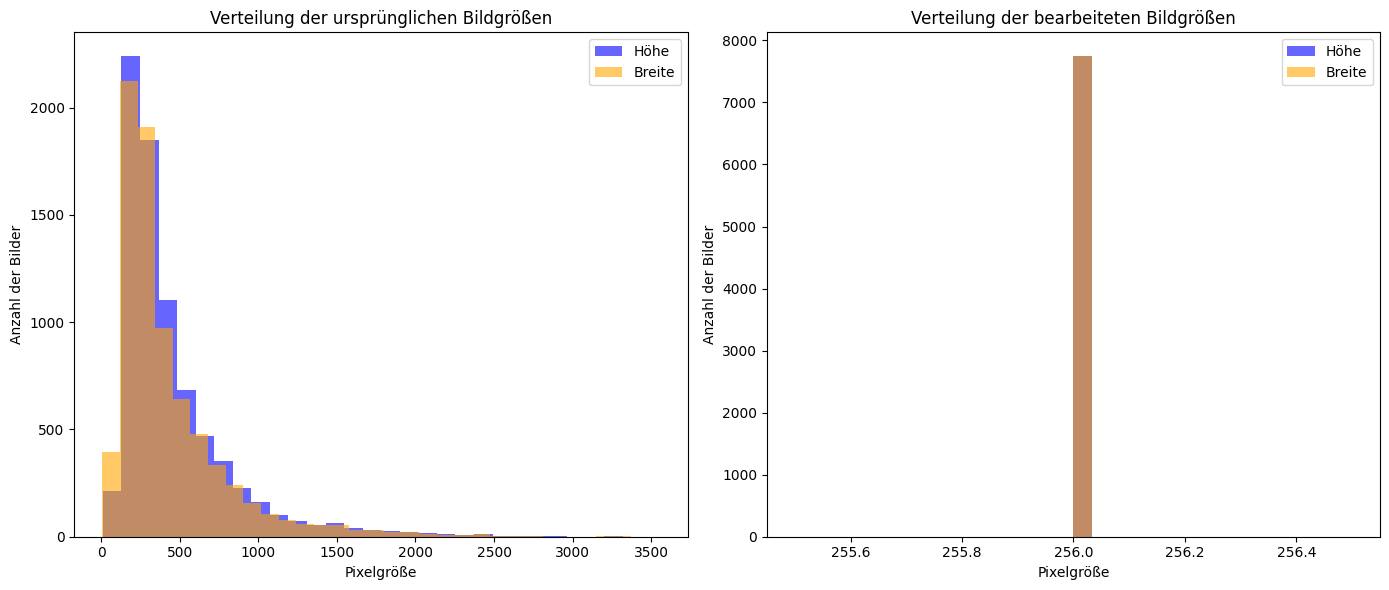

In [ ]:
# Pfade für ursprünglichen und bearbeiteten Datensatz
original_data_dir = 'facial_emotion_dataset'
processed_data_dir = 'facial_emotion_dataset_cleaned'

# Funktion zur Extraktion der Bildgrößen
def get_image_sizes(data_dir):
    heights, widths = [], []
    for root, _, files in os.walk(data_dir):
        for file in files:
            img_path = os.path.join(root, file)
            img = Image.open(img_path)
            width, height = img.size
            widths.append(width)
            heights.append(height)
    return heights, widths

# Bildgrößen für den ursprünglichen und bearbeiteten Datensatz
original_heights, original_widths = get_image_sizes(original_data_dir)
processed_heights, processed_widths = get_image_sizes(processed_data_dir)

# Visualisierung der Verteilung
plt.figure(figsize=(14, 6))

# Ursprüngliche Bildgrößen
plt.subplot(1, 2, 1)
plt.hist(original_heights, bins=30, alpha=0.6, color='blue', label='Höhe')
plt.hist(original_widths, bins=30, alpha=0.6, color='orange', label='Breite')
plt.xlabel('Pixelgröße')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der ursprünglichen Bildgrößen')
plt.legend()

# Bearbeitete Bildgrößen
plt.subplot(1, 2, 2)
plt.hist(processed_heights, bins=30, alpha=0.6, color='blue', label='Höhe')
plt.hist(processed_widths, bins=30, alpha=0.6, color='orange', label='Breite')
plt.xlabel('Pixelgröße')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der bearbeiteten Bildgrößen')
plt.legend()

plt.tight_layout()
plt.show()

Die linke Grafik zeigt die ursprüngliche Verteilung der Bildgrößen im Datensatz vor der Größenanpassung. Hier wird deutlich, dass die Bilder eine große Variation in Höhe und Breite aufweisen, wobei der Großteil der Bilder eine eher kleine Pixelanzahl hat, aber einige bis über 3000 Pixel in Höhe oder Breite erreichen. Diese starke Streuung der Bildgrößen könnte sich negativ auf die Konsistenz der Bildmerkmale im Modelltraining auswirken und verdeutlicht, warum  eine Vereinheitlichung der Auflösung notwendig war.


Die rechte Grafik zeigt die Verteilung der Bildgrößen nach dem Preprocessing. Hier sind alle Bilder auf die einheitliche Größe von 256x256 Pixel skaliert, wodurch eine homogene Verteilung gewährleistet wird. Diese Vereinheitlichung der Auflösung stellt sicher, dass das Modell nicht von unterschiedlichen Bildgrößen beeinflusst wird und stattdessen konsistente Eingaben erhält, was die Verarbeitung und das Training erleichtert und beschleunigt.

<h5 style="color: orange; font-weight: bold;">Baselines:</h5>

Initiales Preprocessing:

In [15]:
# Zufalls-Seed für Reproduzierbarkeit
random_seed = 42
torch.manual_seed(random_seed)

# Definieren der Transformations-Pipelines
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

data_dir = 'facial_emotion_dataset_cleaned'

# Laden des Datensatzes mit spezifischen Transformationen
dataset = ImageFolder(data_dir, transform=transform)

# Aufteilen in Train und Test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

# DataLoader für Training und Test
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, num_workers=4, pin_memory=True)

# Überprüfen der Aufteilung
print(f"Train Dataset Size: {len(train_ds)}")
print(f"Test Dataset Size: {len(test_ds)}")

Train Dataset Size: 6194
Test Dataset Size: 1549


In diesem Schritt wird der Datensatz geladen und in Trainings- und Testdaten aufgeteilt. Der Zufalls-Seed sorgt für Reproduzierbarkeit. Die Normalisierung mit einem Mittelwert von 0,5 und einer Standardabweichung von 0,5 wird sowohl auf die Trainings- als auch auf die Testdaten angewendet. Dies stellt sicher, dass die Daten während des Trainings und der Evaluierung konsistent transformiert werden, wodurch stabile und vergleichbare Ergebnisse erzielt werden.

Ansicht eines Trainingsbatches:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


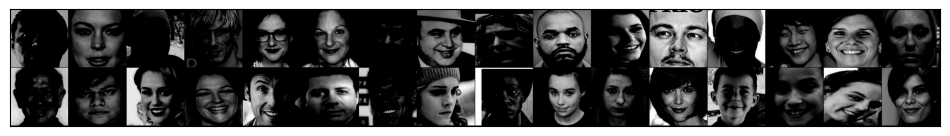

In [16]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break  # Nur das erste Batch anzeigen

# Ein Batch aus dem Trainings-Dataloader anzeigen
show_batch(train_dl)

Festlegen einer heuristischen und ML-Algorithmus Baseline:

In [17]:
# Baseline Heuristik: Immer die häufigste Klasse (hier Neutral)
most_common_label = 1
y_pred_heuristic = np.full(len(test_ds), most_common_label)

# Evaluationsmetriken für die Heuristik
y_true = [label for _, label in test_ds]
print("Heuristik Baseline - Accuracy:", accuracy_score(y_true, y_pred_heuristic))
print("Heuristik Baseline - F1-Score:", f1_score(y_true, y_pred_heuristic, average='weighted'))

# Random Forest als klassischer Baseline-Algorithmus
X_train, y_train = zip(*[(img.flatten().numpy(), label) for img, label in train_ds])
X_test, y_test = zip(*[(img.flatten().numpy(), label) for img, label in test_ds])

# Initialisieren und Trainieren des Random Forest Modells
rf = RandomForestClassifier(random_state=random_seed)
rf.fit(X_train, y_train)

# Vorhersagen für Testdaten
y_pred_rf = rf.predict(X_test)

# Berechne die Evaluationsmetriken für den Random Forest
print("Random Forest Baseline - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Baseline - F1-Score:", f1_score(y_test, y_pred_rf, average='weighted'))

Heuristik Baseline - Accuracy: 0.5216268560361523
Heuristik Baseline - F1-Score: 0.35763640193229623
Random Forest Baseline - Accuracy: 0.8379599741768883
Random Forest Baseline - F1-Score: 0.8371429233753236


**Auswahl der Baselines und Evaluationsmetriken:**

**Heuristische Baseline**: 

Die einfache Heuristik, die immer die häufigste Klasse „Neutral“ (Label 1) vorhersagt, erreicht eine Accuracy von 52,16% und einen F1-Score von 35,76%. Diese Werte zeigen, dass die Vorhersage allein auf Grundlage der häufigsten Klasse eine Grundwahrscheinlichkeit liefert, die nur leicht über dem Zufallsniveau liegt. 

**Random Forest Baseline**: 

Der Random-Forest-Algorithmus wurde als Baseline gewählt, da er gut mit Bilddaten und nicht-linearen Zusammenhängen umgehen kann. Mit einer Accuracy von 83,79% und einem F1-Score von 83,71% liefert er eine deutliche Verbesserung gegenüber der Heuristik. Dies zeigt, dass Random Forest in der Lage ist, feinere Unterschiede zwischen den Klassen zu erkennen und eine leistungsfähigere Baseline für spätere Modellvergleiche darstellt.

**Evaluationsmetriken**: 

Accuracy und F1-Score wurden als Metriken gewählt, um ein umfassendes Bild der Modellleistung zu liefern. 
- **Accuracy** misst den Anteil korrekt klassifizierter Instanzen und eignet sich besonders gut für ausgewogene Datensätze wie diesen.
- **F1-Score** ergänzt die Accuracy durch die Berücksichtigung von Precision und Recall, wodurch die Metrik robust gegenüber Klassenungleichgewichten bleibt. Diese Kombination gewährleistet eine differenzierte Leistungsbewertung der Modelle, die sowohl die Gesamtleistung als auch die Klassentrennung widerspiegelt.

**Ergebnisbewertung**: 

Die deutlich bessere Leistung des Random Forest im Vergleich zur Heuristik bestätigt seine Eignung als verlässliche Baseline.

Confusion Matrix:

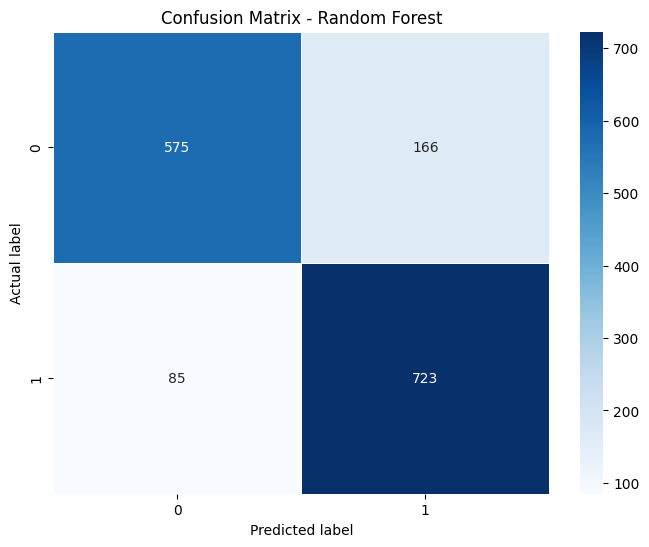

In [19]:
# Berechnung der Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualisierung
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

**Interpretation der Confusion Matrix - Random Forest:**

* **True Negatives (TN)**: 575 — Die meisten "Happy"-Bilder wurden korrekt als "Happy" klassifiziert.
* **False Positives (FP)**: 166 — Einige "Happy"-Bilder wurden fälschlicherweise als "Neutral" klassifiziert. 
* **False Negatives (FN)**: 85— Einige "Neutral"-Bilder wurden als "Happy" klassifiziert.
* **True Positives (TP)**: 723 — Eine große Anzahl der "Neutral"-Bilder wurde korrekt als "Neutral" erkannt, was zeigt, dass das Modell diese Klasse gut identifizieren kann.

**Schlussfolgerung:**

Die Ergebnisse verdeutlichen, dass das Modell gut darin ist, "Neutral"-Bilder zu erkennen, und zeigt auch eine gute Leistung bei der Erkennung von "Happy". Die Fehlklassifikationen könnten darauf hinweisen, dass es Bilder gibt die schwerer zu differenzieren sind da möglicherweise kleinere Merkmale diese unterscheiden. Hier ist es spannend ob das Deep Learning Modell im nächsten Schritt eine bessere Leistung geben wird durch detailliertere Merkmalsunterscheidung. 

<h5 style="color: orange; font-weight: bold;">Deep Learning Experiments</h5>

**Modellwahl und Architekturentscheidung:**

Für die Klassifikation von Emotionen in Gesichtern habe ich mich entschieden, eine eigene (CNN)-Architektur zu entwickeln. Der Aufbau einer eigenen Architektur ermöglicht es, die Modellkomplexität, Anzahl der Schichten und spezifische Layer genau an die Anforderungen meines Datensatzes mit ca. 8.000 Bildern (ca. 4.000 pro Klasse) anzupassen.

**Warum eine eigene CNN-Architektur?**

Eine maßgeschneiderte CNN-Architektur bietet die Flexibilität, gezielt auf die Besonderheiten meines Datensatzes einzugehen, wie z.B. Variationen in Gesichtsausdrücken und Merkmalsverteilung. Mit speziell abgestimmten Schichten (z.B. Convolutional Layers, Batch-Normalization und Dropout) kann ich sicherstellen, dass das Modell relevante Merkmale aus den Bildern effektiv lernt und dabei Overfitting reduziert.

Durch die Entwicklung eines eigenen Modells vermeide ich potenzielle Einschränkungen vortrainierter Modelle und kann die Architektur flexibel anpassen, um optimale Ergebnisse für die Klassifikation der Emotionen "Happy" und "Neutral" zu erzielen.

### Dataset Split:

In [2]:
# Zufalls-Seed für Reproduzierbarkeit setzen
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Transformations-Pipelines für Training, Validierung und Test
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Verzeichnis des cleanen Datensatzes
data_dir = 'facial_emotion_dataset_cleaned'
dataset = ImageFolder(data_dir, transform=train_transform)

# Dataset-Größen berechnen
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Indizes für Training, Validierung und Test zufällig mischen
indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Sampler erstellen
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# DataLoader für jedes Split
train_dl = DataLoader(dataset, batch_size=32, sampler=train_sampler, num_workers=4, pin_memory=True)
val_dl = DataLoader(dataset, batch_size=32, sampler=val_sampler, num_workers=4, pin_memory=True)
test_dl = DataLoader(dataset, batch_size=32, sampler=test_sampler, num_workers=4, pin_memory=True)

# Aufteilung überprüfen
print(f"Train Dataset Size: {len(train_indices)}")
print(f"Validation Dataset Size: {len(val_indices)}")
print(f"Test Dataset Size: {len(test_indices)}")

Train Dataset Size: 5420
Validation Dataset Size: 1161
Test Dataset Size: 1162


In [ ]:
#### Überprüfung auf Überschneidungen zwischen den Splits ###

train_set = set(train_indices)
val_set = set(val_indices)
test_set = set(test_indices)

intersection_train_val = train_set.intersection(val_set)
intersection_train_test = train_set.intersection(test_set)
intersection_val_test = val_set.intersection(test_set)

print(f"Überschneidung zwischen Training und Validierung: {len(intersection_train_val)}")
print(f"Überschneidung zwischen Training und Test: {len(intersection_train_test)}")
print(f"Überschneidung zwischen Validierung und Test: {len(intersection_val_test)}")

# Hilfsfunktion zur Klassenverteilung
def get_class_distribution(dl):
    class_counts = Counter()
    for images, labels in dl:
        class_counts.update(labels.tolist())
    return dict(class_counts)

train_distribution = get_class_distribution(train_dl)
val_distribution = get_class_distribution(val_dl)
test_distribution = get_class_distribution(test_dl)

print(f"Trainingsdaten-Verteilung: {train_distribution}")
print(f"Validierungsdaten-Verteilung: {val_distribution}")
print(f"Testdaten-Verteilung: {test_distribution}")

Überschneidung zwischen Training und Validierung: 0
Überschneidung zwischen Training und Test: 0
Überschneidung zwischen Validierung und Test: 0
Trainingsdaten-Verteilung: {0: 2593, 1: 2827}
Validierungsdaten-Verteilung: {0: 581, 1: 580}
Testdaten-Verteilung: {0: 555, 1: 607}


### Definition der CNN Architektur:

In [4]:
class EmotionCNN(nn.Module):
    def __init__(self, dropout_prob=0.7, fc_neurons=128):
        super(EmotionCNN, self).__init__()
        
        # Convolutional Layers mit Batch Normalization
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) 
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout Layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # Placeholder für Fully Connected Layer
        self.fc1 =  None
        self.fc_neurons = fc_neurons
        self.fc2 = nn.Linear(fc_neurons, 2)  # 2 Output Klassen (Happy und Neutral)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = torch.flatten(x, 1)
        
        # Dynamische Initialisierung für Fully Connected Layer
        if self.fc1 is None:
            num_features = x.shape[1]
            self.fc1 = nn.Linear(num_features, self.fc_neurons).to(x.device)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

Die **EmotionCNN**-Architektur habe ich speziell für die Klassifikation von Emotionen in Graustufenbildern (Happy und Neutral) erstellt.

- **Convolutional Layers**:  
   Die drei Convolutional Layer (`conv1`, `conv2`, `conv3`) extrahieren zunehmend detailliertere Merkmale. Die Kanalanzahl erhöht sich dabei von 1 auf 32, 64 und schließlich 128, um detaillierte Emotionen wie Mikroexpressionen zu erkennen. Nach jedem Convolutional Layer wird Batch Normalization angewendet, um die Stabilität des Trainings zu erhöhen und die Konvergenz zu beschleunigen. 
   ###### Quelle: [Batch-Normalisierung](https://artemoppermann.com/de/batch-normalisierung-in-deep-learning/)


- **Pooling Layer**:  
   Jede Convolutional Layer wird durch einen MaxPooling-Layer ergänzt. Pooling reduziert dabei die Bilddimensionen, was die Modellkomplexität verringert und die Effizienz verbessert.

- **Dropout Layer**:  
   Der gewählte Dropout Layer (Wahrscheinlichkeit: 0.7) verhindert Overfitting und sorgt dafür, dass das Modell die Generalisierungsfähigkeit auf unterschiedliche Emotionen beibehält. Ich habe eine Dropout-Rate von 0.7 gewählt nach testen von mehreren Wahrscheinlichkeiten und der Problematik des Overfittings bei geringeren Werten.

- **Fully Connected Layers**:  
   Die extrahierten Merkmale werden durch zwei fully connected Layers verarbeitet. Der finale Layer gibt die Klassifikation für die Emotionen Happy und Neutral zurück.

Diese Architektur hilft dem Modell, detaillierte Emotionen in vielen Bildern zu erkennen und unterstützt so die Ziele meines Projekts.

### Übertragung auf die GPU:
Da GPUs in der Regel schnellere Berechnungen als CPUs durchführen, werde ich die GPU für die Berechnungen verwenden.

###### Quelle Cuda Setup: https://gist.github.com/aliwaqas333/0f6060664f63ed27471cfa5307f0fb9a

In [5]:
# Gerät prüfen und festlegen
def get_default_device():
    """Pick GPU if available, else CPU"""
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Daten auf das Gerät verschieben
def to_device(data, device):
    """Move tensor(s) to the chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# DataLoader auf das Gerät anwenden
class DeviceDataLoader():
    """Wrap a DataLoader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to the device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
# Gerät auswählen
device = get_default_device()
print("Using device:", device)

Using device: cuda


In [7]:
# Daten und Modell auf das Gerät verschieben
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# Modellinitialisierung
model = EmotionCNN().to(device)
# Loss und Optimizer definieren mit L2-Regularisierung (weight_decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  

### Hyperparameter-Optimierung mittels Random Search

In [ ]:
# Wertebereiche für die Hyperparameter
param_grid = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'dropout_prob': [0.3, 0.5, 0.7],
    'batch_size': [32, 64, 128],
    'fc_neurons': [128, 256, 512] 
}

# Anzahl der zufälligen Kombinationen, die getestet werden sollen
num_combinations = 10

# Funktion zur zufälligen Auswahl einer Kombination aus dem Hyperparameter-Raum
def random_search(param_grid):
    return {key: random.choice(values) for key, values in param_grid.items()}

# Funktion zum Training und zur Validierung für die Hyperparameter-Kombination
def train_and_evaluate(params):
    learning_rate = params['learning_rate']
    dropout_prob = params['dropout_prob']
    batch_size = params['batch_size']
    fc_neurons = params['fc_neurons']
    
    # DataLoader neu setzen mit dem gewählten Batch-Size-Wert und SubsetRandomSampler
    train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=8, pin_memory=True)
    val_dl = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=8, pin_memory=True)

    # Modell und Optimizer initialisieren mit den gegebenen Hyperparametern
    model = EmotionCNN(dropout_prob=dropout_prob, fc_neurons=fc_neurons).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training und Validation für eine festgelegte Anzahl von Epochen
    num_epochs = 5  # Geringe Zahl damit der Durchgang nicht zu lange dauert
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validierung
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_dl:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        
        val_loss /= len(val_dl.dataset)
        # Speichern des besten Modells und Verlusts
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_params = copy.deepcopy(model.state_dict())

    return best_val_loss, best_model_params, params

# Hyperparameter-Suche
best_overall_loss = float('inf')
best_overall_params = None
best_overall_model_params = None

for i in range(num_combinations):
    selected_params = random_search(param_grid)
    val_loss, model_params, params = train_and_evaluate(selected_params)
    print(f"Kombination {i+1}/{num_combinations} - Val Loss: {val_loss:.4f}, Params: {params}")
    
    # Beste Hyperparameter aktualisieren, falls diese Kombination besser ist
    if val_loss < best_overall_loss:
        best_overall_loss = val_loss
        best_overall_params = params
        best_overall_model_params = model_params

print("\nBeste Hyperparameter-Kombination:")
print(best_overall_params)

# Beste Modell mit den besten Parametern laden
model = EmotionCNN(
    dropout_prob=best_overall_params['dropout_prob'],
    fc_neurons=best_overall_params['fc_neurons']
).to(device)
model.load_state_dict(best_overall_model_params, strict=False)
optimizer = optim.Adam(model.parameters(), lr=best_overall_params['learning_rate'])

Kombination 1/10 - Val Loss: 0.0969, Params: {'learning_rate': 1e-05, 'dropout_prob': 0.3, 'batch_size': 32, 'fc_neurons': 512}
Kombination 2/10 - Val Loss: 0.0752, Params: {'learning_rate': 0.0001, 'dropout_prob': 0.3, 'batch_size': 32, 'fc_neurons': 128}
Kombination 3/10 - Val Loss: 0.0997, Params: {'learning_rate': 1e-05, 'dropout_prob': 0.3, 'batch_size': 128, 'fc_neurons': 512}
Kombination 4/10 - Val Loss: 0.0997, Params: {'learning_rate': 1e-05, 'dropout_prob': 0.3, 'batch_size': 128, 'fc_neurons': 256}
Kombination 5/10 - Val Loss: 0.0486, Params: {'learning_rate': 0.001, 'dropout_prob': 0.3, 'batch_size': 32, 'fc_neurons': 128}
Kombination 6/10 - Val Loss: 0.0679, Params: {'learning_rate': 0.001, 'dropout_prob': 0.7, 'batch_size': 128, 'fc_neurons': 128}
Kombination 7/10 - Val Loss: 0.0990, Params: {'learning_rate': 1e-05, 'dropout_prob': 0.3, 'batch_size': 128, 'fc_neurons': 512}
Kombination 8/10 - Val Loss: 0.1011, Params: {'learning_rate': 1e-05, 'dropout_prob': 0.7, 'batch_s

Beste Hyperparameter-Kombination:
{'learning_rate': 0.001, 'dropout_prob': 0.3, 'batch_size': 32, 'fc_neurons': 128}

### Modell Training:

In [8]:
# Initialisierung für Verlaufsspeicherung
history = []

# Loss und Optimizer definieren
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TensorBoard-Writer initialisieren
writer = SummaryWriter()

# Early Stopping Parameter
patience = 4  # Anzahl der Epochen, bevor Early Stopping
best_val_loss = float('inf')
early_stop_counter = 0

# Trainingsschleife
num_epochs = 30
for epoch in range(num_epochs):
    start_time = time.time()

    # Training
    model.train()
    train_loss = 0
    train_correct = 0

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Training Loss aufsummieren
        train_loss += loss.item() * images.size(0)

        # Korrekte Vorhersagen zählen
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    # Training Loss und Genauigkeit berechnen
    train_loss /= len(train_indices)
    train_accuracy = train_correct / len(train_indices)

    # Validierung
    model.eval()
    val_loss = 0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    # Validierung Loss und Genauigkeit berechnen
    val_loss /= len(val_indices)
    val_accuracy = val_correct / len(val_indices)

    # TensorBoard-Einträge
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    # Ausgabe pro Epoche
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Time: {elapsed_time:.2f}s')

    # TensorBoard-Einträge
    writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'train': train_accuracy, 'val': val_accuracy}, epoch)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Bestes Modell speichern
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# TensorBoard schließen
writer.close()

Epoch 1/30, Train Loss: 0.6717, Train Acc: 0.5775, Val Loss: 0.6327, Val Acc: 0.6718, Time: 23.02s
Epoch 2/30, Train Loss: 0.6268, Train Acc: 0.6557, Val Loss: 0.5778, Val Acc: 0.7485, Time: 22.08s
Epoch 3/30, Train Loss: 0.5933, Train Acc: 0.6902, Val Loss: 0.5380, Val Acc: 0.7614, Time: 22.30s
Epoch 4/30, Train Loss: 0.5443, Train Acc: 0.7297, Val Loss: 0.4883, Val Acc: 0.7967, Time: 22.31s
Epoch 5/30, Train Loss: 0.5057, Train Acc: 0.7557, Val Loss: 0.4484, Val Acc: 0.8329, Time: 22.11s
Epoch 6/30, Train Loss: 0.4751, Train Acc: 0.7707, Val Loss: 0.4471, Val Acc: 0.8045, Time: 22.30s
Epoch 7/30, Train Loss: 0.4539, Train Acc: 0.7825, Val Loss: 0.3853, Val Acc: 0.8553, Time: 21.90s
Epoch 8/30, Train Loss: 0.4380, Train Acc: 0.7950, Val Loss: 0.3656, Val Acc: 0.8648, Time: 22.09s
Epoch 9/30, Train Loss: 0.4093, Train Acc: 0.8094, Val Loss: 0.3576, Val Acc: 0.8665, Time: 22.11s
Epoch 10/30, Train Loss: 0.3973, Train Acc: 0.8155, Val Loss: 0.3338, Val Acc: 0.8811, Time: 21.93s
Epoch 11/

<h5 style="color: orange; font-weight: bold;">Evaluation des Lernfortschritts</h5>

![loss_tensorboard](Loss_Eval.png)

![accuracy_tensorboard](Accuracy_Eval.png)

**Loss-Plot:**

- Der Trainingsverlust sinkt kontinuierlich und zeigt, dass das Modell seine Fehler reduziert.
- Der Validierungsverlust zeigt ebenfalls eine Abnahme mit leichten Schwankungen, was eine gute Generalisierung ohne signifikantes Overfitting nahelegt.
- Kein drastischer Anstieg im Validierungsverlust deutet auf ein solides und stabiles Training hin.

**Accuracy-Plot:**

- Die Trainingsgenauigkeit steigt stetig, was auf gutes Lernen der Trainingsdaten hinweist.
- Die Validierungsgenauigkeit zeigt ebenfalls einen Anstieg mit leichten Schwankungen, was auf eine stabile, wenn auch nicht perfekte Generalisierung hindeutet.
- Die moderate Differenz zwischen Training und Validierung spricht für eine gute Balance und akzeptable Generalisierung.

**Fazit:**

Die Plots deuten auf eine solide Modellanpassung hin, mit leichten Schwankungen in der Generalisierung. Zur Reduktion von Overfitting wurde der Dropout-Wert von den empfohlenen 0,3 auf 0,7 erhöht. Dies führte zu einer stabileren Validierungsleistung und half, die Lücke zwischen Trainings- und Validierungsgenauigkeit zu verringern.

### Dropout-Werte unter unter 0.6: 

![tensorboard](Low_Dropout.png)

### Einfluss der Dropout-Werte: Vergleich zwischen Dropout 0.7 und niedriger als 0.6

#### Ergebnisse mit Dropout < 0.6

- **Accuracy-Plot**: Bei einem Dropout-Wert unter 0.6 zeigt der Verlauf der Trainingsgenauigkeit ein starkes Wachstum, während die Validierungsgenauigkeit langsamer ansteigt und eine geringere Endgenauigkeit erreicht. Die enge Überlappung zwischen Training und Validierung wird zunehmend durch eine stärkere Diskrepanz ersetzt, was auf Overfitting hindeutet.
- **Loss-Plot**: Der Verlustverlauf zeigt, dass der Trainingsverlust stetig sinkt, aber der Validierungsverlust eine geringere Verbesserung aufweist oder sogar stagniert, was ebenfalls auf Überanpassung des Modells an die Trainingsdaten hinweist.

#### Vergleichende Interpretation:

- **Dropout 0.7 (Bestes Ergebnis)**: Hier war die Balance zwischen Trainings- und Validierungsleistung gut, was zu einer verbesserten Generalisierungsleistung führte.
- **Dropout < 0.6**: Die Abnahme der Regularisierung führte zu einer schlechteren Generalisierung und höheren Diskrepanzen zwischen Training und Validierung, was durch das Überanpassen an die Trainingsdaten belegt wird.

#### Fazit:

Die Wahl eines höheren Dropout-Wertes von 0.7 erwies sich als optimal, um Overfitting zu vermeiden und die Validierungsleistung zu verbessern. Die Visualisierung verdeutlicht, dass eine zu geringe Regularisierung durch zu niedrige Dropout-Werte zu schlechteren Ergebnissen führt, insbesondere im Hinblick auf die Generalisierungsfähigkeit des Modells.

<h5 style="color: orange; font-weight: bold;">Evaluierung des Modells auf Testdaten und Baseline Vergleich</h5>

In [ ]:
# Modell in den Evaluierungsmodus setzen
model.eval()

# Testen des Modells
test_loss = 0
test_correct = 0
y_test_true = []
y_test_pred = []

with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        # Korrekte Vorhersagen zählen
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()

        # Für spätere Metrik-Berechnungen sammeln
        y_test_true.extend(labels.cpu().numpy())
        y_test_pred.extend(preds.cpu().numpy())

# Test-Loss und -Genauigkeit berechnen
test_loss /= len(test_indices)
test_accuracy = test_correct / len(test_indices)

# Berechnung des gewichteten F1-Scores
weighted_f1 = f1_score(y_test_true, y_test_pred, average='weighted')

# Ergebnisse ausgeben
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Weighted F1-Score: {weighted_f1:.4f}')

# Vergleichstabelle
print("\n| Dataset      | Loss  | Accuracy |")
print("|--------------|-------|----------|")
print(f"| Training     | {train_loss:.4f} | {train_accuracy:.4f} |")
print(f"| Validation   | {val_loss:.4f} | {val_accuracy:.4f} |")

Test Loss: 0.2746, Test Accuracy: 0.8941, Weighted F1-Score: 0.8940

| Dataset      | Loss  | Accuracy |
|--------------|-------|----------|
| Training     | 0.2719 | 0.8821 |
| Validation   | 0.2778 | 0.8837 |


| Modell                    | Accuracy (Test) | F1-Score (Test) | 
|---------------------------|-----------------|-----------------|
| Deep Learning Modell      | 0.8941          | 0.8940          |
| Heuristik Baseline        | 0.5216          | 0.3576          | 
| Random Forest Baseline    | 0.8379          | 0.8371          |

Die Ergebnisse zeigen, dass das Deep-Learning-Modell mit einer Test-Accuracy von 89,41% und einem gewichteten F1-Score von 0,8940 die beste Performance im Vergleich zu den Baselines erreicht. Während der Random Forest eine ähnliche Leistung zeigt (Accuracy von 83,79% und F1-Score von 0,8371), übertrifft das Deep-Learning-Modell ihn leicht und demonstriert eine bessere Erkennung komplexer Merkmale. Die geringe Differenz zwischen Trainings-, Validierungs- und Test-Performance des Deep-Learning-Modells deutet zudem auf eine gute Generalisierungsfähigkeit hin.

<h5 style="color: orange; font-weight: bold;">Conclusions and Future Work</h5>

### Zusammenfassung und Interpretation der Ergebnisse
Das entwickelte Deep-Learning-Modell zur Klassifikation von Emotionen erzielte eine Test-Accuracy von **89,41%** und einen gewichteten F1-Score von **0,8940**. Diese Ergebnisse zeigen, dass das Modell komplexe Merkmale aus den Bilddaten zuverlässig extrahiert und die Emotionen präzise klassifiziert. Im Vergleich zur Heuristik-Baseline und der Random-Forest-Baseline übertrifft das Modell die Leistung, wenn auch nicht dramatisch gegenüber dem Random Forest. Die geringe Differenz zwischen den Trainings-, Validierungs- und Test-Ergebnissen deutet auf eine gute Generalisierung hin und darauf, dass das Modell weder stark unter- noch überfitted ist.

### Empfehlung für die Organisation
Basierend auf den erzielten Ergebnissen sollte die Organisation das Deep-Learning-Modell für die automatische Erkennung von Emotionen implementieren. Dies könnte insbesondere in Echtzeit-Umgebungen wie Arcade-Arenen nützlich sein, um emotionale Reaktionen der Nutzer zu erfassen und daraus Einblicke zu gewinnen. Das Modell bietet eine verlässliche Grundlage für emotionale Analysen, könnte jedoch durch Modellverbesserungen weiter optimiert werden.

### Einschränkungen und mögliche Fallstricke
- **Begrenzte Generalisierungsfähigkeit**: Das Modell wurde auf nur zwei Emotionen trainiert, was die Anwendbarkeit auf breitere Szenarien einschränkt. Eine Erweiterung auf weitere Emotionen ist notwendig, um breitere Einblicke zu ermöglichen.
- **Datensatz-Bias**: Falls der Datensatz bestimmte Gruppen oder Gesichtstypen bevorzugt, kann dies zu Verzerrungen führen. Dies könnte zu einer geringeren Genauigkeit bei unterrepräsentierten Gruppen führen.
- **Unterschiedliche Lichtverhältnisse und Bildqualität**: Variationen in Lichtverhältnissen, Gesichtsausdrücken oder Bildqualität könnten zu unvorhersehbaren Ergebnissen in realen Anwendungen führen.

### Vorschläge für zukünftige Arbeiten
1. **Erweiterung um zusätzliche Emotionen**: Das Hinzufügen weiterer Emotionen würde die Anwendbarkeit des Modells erhöhen und einen umfassenderen Überblick über emotionale Reaktionen ermöglichen.
2. **Einsatz von Transfer Learning**: Der Einsatz vortrainierter Modelle wie VGG16 oder ResNet könnte durch bessere Merkmalsextraktion zu noch präziseren Ergebnissen führen und den Trainingsaufwand verringern.
3. **Datenerweiterung durch Augmentation**: Durch den Einsatz von Bildaugmentierungstechniken wie Drehung, Skalierung oder Beleuchtungsanpassungen könnte die Robustheit des Modells gegenüber unterschiedlichen Bildbedingungen erhöht werden.

### Kritische Diskussion der angewandten Methodik
Die gewählte Modellarchitektur mit drei Convolutional Layers, Batch-Normalization und Dropout führte zu soliden Ergebnissen. Dennoch hätten andere Architekturen wie tiefere vortrainierte CNNs zusätzliche Einblicke bieten können. Die Hyperparameter-Optimierung durch Random Search war ein guter Ausgangspunkt, könnte aber durch Methoden wie Grid Search erweitert werden. Auch die Auswahl der Dropout-Werte und die Balance zwischen Regularisierung und Modellkapazität waren wichtig, könnten jedoch durch weitergehende Tests noch optimiert werden.

### Reflexion der ursprünglichen Aufgabenstellung
Die ursprünglichen Ziele waren realistisch und wurden größtenteils erreicht. Eine mögliche Erweiterung auf mehr Emotionen hätte den Nutzen des Modells für die Organisation weiter gesteigert. Zudem hätte eine größere Datensammlung mit vielfältigeren Emotionen die Robustheit und Generalisierungsfähigkeit verbessern können.